In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


dropout_value = 0.1

def conv_bn_act(in_ch, out_ch, kernel=3, stride=1, padding=1, dilation=1, dropout_p=0.05):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=kernel, stride=stride,
                  padding=padding, dilation=dilation, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_p)
    )

def dws_bn_act(in_ch, out_ch, kernel_size=3, stride=1, padding=1, dilation=1,dropout_p=0.05):
    return nn.Sequential(
        nn.Conv2d(in_ch, in_ch, kernel_size=kernel_size, stride=stride,
                            padding=padding, dilation=dilation, groups=in_ch, bias=False),
        nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_p)
    )

class Model1(nn.Module):
    def __init__(self, num_classes):
        super(Model1, self).__init__()

        # CONVOLUTION BLOCK 1
        self.c1_1 = conv_bn_act(3, 32, kernel=3, stride=1, padding=1, dilation=1)
        self.c1_2 = conv_bn_act(32, 64, kernel=3, stride=2, padding=1, dilation=1)
        self.onexonec1_1 = conv_bn_act(64, 16, kernel=1, stride=1, padding=0, dilation=1)

        # CONVOLUTION BLOCK 2
        self.c2_1 = conv_bn_act(16, 32, kernel=3, stride=1, padding=1, dilation=1)
        self.c2_2 = dws_bn_act(32, 16, kernel_size=3, stride=2, padding=1, dilation=1)
        #self.onexonec2_1 = conv_bn_act(64, 32, kernel=1, stride=1, padding=0, dilation=1)

        # CONVOLUTION BLOCK 3
        self.c3_1 = conv_bn_act(16, 32, kernel=3, stride=1, padding=1, dilation=1)
        self.c3_2 = conv_bn_act(32, 64, kernel=3, stride=1, padding=1, dilation=1)
        self.onexonec3_1 = conv_bn_act(64, 16, kernel=1, stride=1, padding=0, dilation=1)

        # CONVOLUTION BLOCK 4
        self.c4_1 = conv_bn_act(16, 32, kernel=3, stride=1, padding=1, dilation=1)
        self.c4_2 = conv_bn_act(32, 64, kernel=3, stride=1, padding=1, dilation=1)
        self.c5 = conv_bn_act(64, 32, kernel=3, stride=1, padding=1, dilation=2)

        # OUTPUT BLOCK
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(32, num_classes)


    def forward(self, x):
        # Block 1
        x = self.c1_1(x)
        x = self.c1_2(x)
        x = self.onexonec1_1(x)

        # Block 2
        x = self.c2_1(x)
        x = self.c2_2(x)
        #x = self.onexonec2_1(x)

        # Block 3
        x = self.c3_1(x)
        x = self.c3_2(x)
        x = self.onexonec3_1(x)

        # Block 4 (dilated)
        x = self.c4_1(x)
        x = self.c4_2(x)
        x = self.c5(x)

        # Output Block
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        # x = x.view(-1, 10)
        return x

In [2]:
import matplotlib.pyplot as plt


def plot_metrics(train_losses, test_losses, train_acc, test_acc):
    epochs = range(1, len(train_acc) + 1)

    # ----------------------
    # Plot Train Loss
    # ----------------------
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Train Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------
    # Plot Test Loss
    # ----------------------
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, test_losses, 'r-', label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Test Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------
    # Plot Train Accuracy
    # ----------------------
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_acc, 'g-', label='Train Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy (%)')
    plt.title('Train Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------
    # Plot Test Accuracy
    # ----------------------
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, test_acc, 'm-', label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]


CUDA Available? True
Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 16, 16]          18,432
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
           Dropout-8           [-1, 64, 16, 16]               0
            Conv2d-9           [-1, 16, 16, 16]           1,024
      BatchNorm2d-10           [-1, 16, 16, 16]              32
             ReLU-11           [-1, 16, 16, 16]               0
          Dropout-12           [-1, 16, 16, 16]               0
           Conv2d-13           [-1, 32, 16, 16]           4,608
      BatchNorm2d-14           [-1, 32,

Epoch=1 Loss=2.0002 Accuracy=19.58: 100%|██████████| 391/391 [00:21<00:00, 18.13it/s]



Test set: Average loss: 0.0156, Accuracy: 2567/10000 (25.67%)

found perfect model!!
Saved best model (acc=25.67%) to best_model.pth

EPOCH: 2


Epoch=2 Loss=1.8868 Accuracy=29.41: 100%|██████████| 391/391 [00:19<00:00, 19.90it/s]



Test set: Average loss: 0.0142, Accuracy: 3362/10000 (33.62%)

found perfect model!!
Saved best model (acc=33.62%) to best_model.pth

EPOCH: 3


Epoch=3 Loss=1.8216 Accuracy=34.99: 100%|██████████| 391/391 [00:20<00:00, 18.63it/s]



Test set: Average loss: 0.0127, Accuracy: 4018/10000 (40.18%)

found perfect model!!
Saved best model (acc=40.18%) to best_model.pth

EPOCH: 4


Epoch=4 Loss=1.6157 Accuracy=40.55: 100%|██████████| 391/391 [00:20<00:00, 19.30it/s]



Test set: Average loss: 0.0115, Accuracy: 4649/10000 (46.49%)

found perfect model!!
Saved best model (acc=46.49%) to best_model.pth

EPOCH: 5


Epoch=5 Loss=1.6717 Accuracy=45.01: 100%|██████████| 391/391 [00:19<00:00, 20.34it/s]



Test set: Average loss: 0.0103, Accuracy: 5224/10000 (52.24%)

found perfect model!!
Saved best model (acc=52.24%) to best_model.pth

EPOCH: 6


Epoch=6 Loss=1.4599 Accuracy=48.86: 100%|██████████| 391/391 [00:20<00:00, 19.19it/s]



Test set: Average loss: 0.0095, Accuracy: 5630/10000 (56.30%)

found perfect model!!
Saved best model (acc=56.30%) to best_model.pth

EPOCH: 7


Epoch=7 Loss=1.2851 Accuracy=52.00: 100%|██████████| 391/391 [00:19<00:00, 20.14it/s]



Test set: Average loss: 0.0090, Accuracy: 5900/10000 (59.00%)

found perfect model!!
Saved best model (acc=59.00%) to best_model.pth

EPOCH: 8


Epoch=8 Loss=1.1936 Accuracy=54.20: 100%|██████████| 391/391 [00:19<00:00, 20.41it/s]



Test set: Average loss: 0.0084, Accuracy: 6213/10000 (62.13%)

found perfect model!!
Saved best model (acc=62.13%) to best_model.pth

EPOCH: 9


Epoch=9 Loss=1.1123 Accuracy=56.31: 100%|██████████| 391/391 [00:20<00:00, 19.18it/s]



Test set: Average loss: 0.0078, Accuracy: 6408/10000 (64.08%)

found perfect model!!
Saved best model (acc=64.08%) to best_model.pth

EPOCH: 10


Epoch=10 Loss=0.9096 Accuracy=58.27: 100%|██████████| 391/391 [00:19<00:00, 20.28it/s]



Test set: Average loss: 0.0077, Accuracy: 6510/10000 (65.10%)

found perfect model!!
Saved best model (acc=65.10%) to best_model.pth

EPOCH: 11


Epoch=11 Loss=1.0461 Accuracy=60.06: 100%|██████████| 391/391 [00:20<00:00, 19.24it/s]



Test set: Average loss: 0.0072, Accuracy: 6691/10000 (66.91%)

found perfect model!!
Saved best model (acc=66.91%) to best_model.pth

EPOCH: 12


Epoch=12 Loss=1.1812 Accuracy=61.73: 100%|██████████| 391/391 [00:19<00:00, 19.97it/s]



Test set: Average loss: 0.0076, Accuracy: 6616/10000 (66.16%)


EPOCH: 13


Epoch=13 Loss=1.1266 Accuracy=62.83: 100%|██████████| 391/391 [00:19<00:00, 19.66it/s]



Test set: Average loss: 0.0067, Accuracy: 7020/10000 (70.20%)

found perfect model!!
Saved best model (acc=70.20%) to best_model.pth

EPOCH: 14


Epoch=14 Loss=0.8683 Accuracy=64.14: 100%|██████████| 391/391 [00:19<00:00, 19.57it/s]



Test set: Average loss: 0.0068, Accuracy: 6928/10000 (69.28%)


EPOCH: 15


Epoch=15 Loss=0.9463 Accuracy=65.06: 100%|██████████| 391/391 [00:18<00:00, 20.69it/s]



Test set: Average loss: 0.0069, Accuracy: 6954/10000 (69.54%)


EPOCH: 16


Epoch=16 Loss=0.8844 Accuracy=65.82: 100%|██████████| 391/391 [00:20<00:00, 19.29it/s]



Test set: Average loss: 0.0064, Accuracy: 7147/10000 (71.47%)

found perfect model!!
Saved best model (acc=71.47%) to best_model.pth

EPOCH: 17


Epoch=17 Loss=0.8517 Accuracy=66.82: 100%|██████████| 391/391 [00:18<00:00, 20.77it/s]



Test set: Average loss: 0.0057, Accuracy: 7427/10000 (74.27%)

found perfect model!!
Saved best model (acc=74.27%) to best_model.pth

EPOCH: 18


Epoch=18 Loss=0.8899 Accuracy=67.74: 100%|██████████| 391/391 [00:19<00:00, 19.71it/s]



Test set: Average loss: 0.0059, Accuracy: 7368/10000 (73.68%)


EPOCH: 19


Epoch=19 Loss=1.0219 Accuracy=68.24: 100%|██████████| 391/391 [00:19<00:00, 19.65it/s]



Test set: Average loss: 0.0056, Accuracy: 7516/10000 (75.16%)

found perfect model!!
Saved best model (acc=75.16%) to best_model.pth

EPOCH: 20


Epoch=20 Loss=0.8869 Accuracy=68.65: 100%|██████████| 391/391 [00:19<00:00, 20.35it/s]



Test set: Average loss: 0.0055, Accuracy: 7555/10000 (75.55%)

found perfect model!!
Saved best model (acc=75.55%) to best_model.pth

EPOCH: 21


Epoch=21 Loss=0.7102 Accuracy=69.56: 100%|██████████| 391/391 [00:21<00:00, 18.33it/s]



Test set: Average loss: 0.0051, Accuracy: 7751/10000 (77.51%)

found perfect model!!
Saved best model (acc=77.51%) to best_model.pth

EPOCH: 22


Epoch=22 Loss=0.6476 Accuracy=69.69: 100%|██████████| 391/391 [00:19<00:00, 19.78it/s]



Test set: Average loss: 0.0052, Accuracy: 7703/10000 (77.03%)


EPOCH: 23


Epoch=23 Loss=0.7444 Accuracy=69.85: 100%|██████████| 391/391 [00:19<00:00, 19.99it/s]



Test set: Average loss: 0.0052, Accuracy: 7694/10000 (76.94%)


EPOCH: 24


Epoch=24 Loss=0.5914 Accuracy=70.49: 100%|██████████| 391/391 [00:20<00:00, 19.30it/s]



Test set: Average loss: 0.0049, Accuracy: 7784/10000 (77.84%)

found perfect model!!
Saved best model (acc=77.84%) to best_model.pth

EPOCH: 25


Epoch=25 Loss=1.0081 Accuracy=70.80: 100%|██████████| 391/391 [00:19<00:00, 20.33it/s]



Test set: Average loss: 0.0051, Accuracy: 7785/10000 (77.85%)

found perfect model!!
Saved best model (acc=77.85%) to best_model.pth

EPOCH: 26


Epoch=26 Loss=0.9620 Accuracy=71.02: 100%|██████████| 391/391 [00:20<00:00, 19.13it/s]



Test set: Average loss: 0.0050, Accuracy: 7813/10000 (78.13%)

found perfect model!!
Saved best model (acc=78.13%) to best_model.pth

EPOCH: 27


Epoch=27 Loss=0.8064 Accuracy=71.74: 100%|██████████| 391/391 [00:19<00:00, 20.09it/s]



Test set: Average loss: 0.0049, Accuracy: 7816/10000 (78.16%)

found perfect model!!
Saved best model (acc=78.16%) to best_model.pth

EPOCH: 28


Epoch=28 Loss=0.6570 Accuracy=71.58: 100%|██████████| 391/391 [00:19<00:00, 19.56it/s]



Test set: Average loss: 0.0050, Accuracy: 7818/10000 (78.18%)

found perfect model!!
Saved best model (acc=78.18%) to best_model.pth

EPOCH: 29


Epoch=29 Loss=0.5593 Accuracy=72.06: 100%|██████████| 391/391 [00:19<00:00, 20.10it/s]



Test set: Average loss: 0.0047, Accuracy: 7939/10000 (79.39%)

found perfect model!!
Saved best model (acc=79.39%) to best_model.pth

EPOCH: 30


Epoch=30 Loss=0.5878 Accuracy=72.30: 100%|██████████| 391/391 [00:18<00:00, 21.09it/s]



Test set: Average loss: 0.0052, Accuracy: 7770/10000 (77.70%)


EPOCH: 31


Epoch=31 Loss=0.9945 Accuracy=72.64: 100%|██████████| 391/391 [00:19<00:00, 20.01it/s]



Test set: Average loss: 0.0048, Accuracy: 7956/10000 (79.56%)

found perfect model!!
Saved best model (acc=79.56%) to best_model.pth

EPOCH: 32


Epoch=32 Loss=0.7216 Accuracy=72.80: 100%|██████████| 391/391 [00:18<00:00, 20.84it/s]



Test set: Average loss: 0.0049, Accuracy: 7849/10000 (78.49%)


EPOCH: 33


Epoch=33 Loss=0.8515 Accuracy=72.90: 100%|██████████| 391/391 [00:19<00:00, 19.56it/s]



Test set: Average loss: 0.0046, Accuracy: 8027/10000 (80.27%)

found perfect model!!
Saved best model (acc=80.27%) to best_model.pth

EPOCH: 34


Epoch=34 Loss=0.9907 Accuracy=73.41: 100%|██████████| 391/391 [00:18<00:00, 21.13it/s]



Test set: Average loss: 0.0043, Accuracy: 8048/10000 (80.48%)

found perfect model!!
Saved best model (acc=80.48%) to best_model.pth

EPOCH: 35


Epoch=35 Loss=0.8681 Accuracy=73.71: 100%|██████████| 391/391 [00:19<00:00, 20.12it/s]



Test set: Average loss: 0.0044, Accuracy: 8070/10000 (80.70%)

found perfect model!!
Saved best model (acc=80.70%) to best_model.pth

EPOCH: 36


Epoch=36 Loss=0.7526 Accuracy=73.68: 100%|██████████| 391/391 [00:18<00:00, 21.29it/s]



Test set: Average loss: 0.0044, Accuracy: 8084/10000 (80.84%)

found perfect model!!
Saved best model (acc=80.84%) to best_model.pth

EPOCH: 37


Epoch=37 Loss=0.6341 Accuracy=73.94: 100%|██████████| 391/391 [00:19<00:00, 19.93it/s]



Test set: Average loss: 0.0042, Accuracy: 8224/10000 (82.24%)

found perfect model!!
Saved best model (acc=82.24%) to best_model.pth

EPOCH: 38


Epoch=38 Loss=0.6523 Accuracy=74.23: 100%|██████████| 391/391 [00:18<00:00, 21.40it/s]



Test set: Average loss: 0.0043, Accuracy: 8151/10000 (81.51%)


EPOCH: 39


Epoch=39 Loss=0.8711 Accuracy=74.48: 100%|██████████| 391/391 [00:19<00:00, 19.58it/s]



Test set: Average loss: 0.0045, Accuracy: 8073/10000 (80.73%)


EPOCH: 40


Epoch=40 Loss=0.8961 Accuracy=74.49: 100%|██████████| 391/391 [00:19<00:00, 20.00it/s]



Test set: Average loss: 0.0043, Accuracy: 8159/10000 (81.59%)


EPOCH: 41


Epoch=41 Loss=0.7181 Accuracy=74.95: 100%|██████████| 391/391 [00:18<00:00, 20.85it/s]



Test set: Average loss: 0.0041, Accuracy: 8205/10000 (82.05%)


EPOCH: 42


Epoch=42 Loss=0.6727 Accuracy=74.71: 100%|██████████| 391/391 [00:20<00:00, 19.04it/s]



Test set: Average loss: 0.0044, Accuracy: 8075/10000 (80.75%)


EPOCH: 43


Epoch=43 Loss=0.5930 Accuracy=75.00: 100%|██████████| 391/391 [00:19<00:00, 20.44it/s]



Test set: Average loss: 0.0044, Accuracy: 8057/10000 (80.57%)


EPOCH: 44


Epoch=44 Loss=0.4716 Accuracy=75.34: 100%|██████████| 391/391 [00:20<00:00, 19.37it/s]



Test set: Average loss: 0.0040, Accuracy: 8220/10000 (82.20%)


EPOCH: 45


Epoch=45 Loss=0.8495 Accuracy=75.66: 100%|██████████| 391/391 [00:20<00:00, 19.38it/s]



Test set: Average loss: 0.0041, Accuracy: 8177/10000 (81.77%)


EPOCH: 46


Epoch=46 Loss=0.5432 Accuracy=75.49: 100%|██████████| 391/391 [00:19<00:00, 19.74it/s]



Test set: Average loss: 0.0040, Accuracy: 8244/10000 (82.44%)

found perfect model!!
Saved best model (acc=82.44%) to best_model.pth

EPOCH: 47


Epoch=47 Loss=0.6235 Accuracy=75.98: 100%|██████████| 391/391 [00:20<00:00, 18.72it/s]



Test set: Average loss: 0.0039, Accuracy: 8286/10000 (82.86%)

found perfect model!!
Saved best model (acc=82.86%) to best_model.pth

EPOCH: 48


Epoch=48 Loss=0.6899 Accuracy=76.06: 100%|██████████| 391/391 [00:19<00:00, 20.01it/s]



Test set: Average loss: 0.0039, Accuracy: 8262/10000 (82.62%)


EPOCH: 49


Epoch=49 Loss=0.5012 Accuracy=76.14: 100%|██████████| 391/391 [00:20<00:00, 18.98it/s]



Test set: Average loss: 0.0038, Accuracy: 8365/10000 (83.65%)

found perfect model!!
Saved best model (acc=83.65%) to best_model.pth

EPOCH: 50


Epoch=50 Loss=0.6600 Accuracy=76.17: 100%|██████████| 391/391 [00:19<00:00, 19.77it/s]



Test set: Average loss: 0.0039, Accuracy: 8315/10000 (83.15%)


EPOCH: 51


Epoch=51 Loss=0.8176 Accuracy=76.33: 100%|██████████| 391/391 [00:19<00:00, 19.89it/s]



Test set: Average loss: 0.0039, Accuracy: 8245/10000 (82.45%)


EPOCH: 52


Epoch=52 Loss=0.6320 Accuracy=76.42: 100%|██████████| 391/391 [00:20<00:00, 18.71it/s]



Test set: Average loss: 0.0037, Accuracy: 8331/10000 (83.31%)


EPOCH: 53


Epoch=53 Loss=0.6481 Accuracy=76.89: 100%|██████████| 391/391 [00:19<00:00, 20.05it/s]



Test set: Average loss: 0.0038, Accuracy: 8339/10000 (83.39%)


EPOCH: 54


Epoch=54 Loss=0.6629 Accuracy=76.91: 100%|██████████| 391/391 [00:20<00:00, 18.75it/s]



Test set: Average loss: 0.0037, Accuracy: 8382/10000 (83.82%)

found perfect model!!
Saved best model (acc=83.82%) to best_model.pth

EPOCH: 55


Epoch=55 Loss=0.9218 Accuracy=77.15: 100%|██████████| 391/391 [00:20<00:00, 19.24it/s]



Test set: Average loss: 0.0038, Accuracy: 8346/10000 (83.46%)


EPOCH: 56


Epoch=56 Loss=0.8345 Accuracy=76.73: 100%|██████████| 391/391 [00:19<00:00, 20.00it/s]



Test set: Average loss: 0.0037, Accuracy: 8364/10000 (83.64%)


EPOCH: 57


Epoch=57 Loss=0.6126 Accuracy=77.25: 100%|██████████| 391/391 [00:20<00:00, 18.64it/s]



Test set: Average loss: 0.0037, Accuracy: 8367/10000 (83.67%)


EPOCH: 58


Epoch=58 Loss=0.7614 Accuracy=77.31: 100%|██████████| 391/391 [00:19<00:00, 20.13it/s]



Test set: Average loss: 0.0036, Accuracy: 8427/10000 (84.27%)

found perfect model!!
Saved best model (acc=84.27%) to best_model.pth

EPOCH: 59


Epoch=59 Loss=0.6854 Accuracy=77.40: 100%|██████████| 391/391 [00:20<00:00, 18.75it/s]



Test set: Average loss: 0.0037, Accuracy: 8387/10000 (83.87%)


EPOCH: 60


Epoch=60 Loss=0.5720 Accuracy=77.46: 100%|██████████| 391/391 [00:19<00:00, 19.92it/s]



Test set: Average loss: 0.0036, Accuracy: 8439/10000 (84.39%)

found perfect model!!
Saved best model (acc=84.39%) to best_model.pth

EPOCH: 61


Epoch=61 Loss=0.6017 Accuracy=77.24: 100%|██████████| 391/391 [00:19<00:00, 20.50it/s]



Test set: Average loss: 0.0036, Accuracy: 8429/10000 (84.29%)


EPOCH: 62


Epoch=62 Loss=0.6483 Accuracy=77.79: 100%|██████████| 391/391 [00:20<00:00, 19.23it/s]



Test set: Average loss: 0.0036, Accuracy: 8430/10000 (84.30%)


EPOCH: 63


Epoch=63 Loss=0.3760 Accuracy=77.80: 100%|██████████| 391/391 [00:19<00:00, 20.40it/s]



Test set: Average loss: 0.0035, Accuracy: 8461/10000 (84.61%)

found perfect model!!
Saved best model (acc=84.61%) to best_model.pth

EPOCH: 64


Epoch=64 Loss=0.6661 Accuracy=77.96: 100%|██████████| 391/391 [00:20<00:00, 18.97it/s]



Test set: Average loss: 0.0035, Accuracy: 8447/10000 (84.47%)


EPOCH: 65


Epoch=65 Loss=0.6809 Accuracy=77.92: 100%|██████████| 391/391 [00:19<00:00, 20.20it/s]



Test set: Average loss: 0.0035, Accuracy: 8469/10000 (84.69%)

found perfect model!!
Saved best model (acc=84.69%) to best_model.pth

EPOCH: 66


Epoch=66 Loss=0.5377 Accuracy=78.33: 100%|██████████| 391/391 [00:20<00:00, 18.90it/s]



Test set: Average loss: 0.0035, Accuracy: 8491/10000 (84.91%)

found perfect model!!
Saved best model (acc=84.91%) to best_model.pth

EPOCH: 67


Epoch=67 Loss=0.4668 Accuracy=78.14: 100%|██████████| 391/391 [00:20<00:00, 19.28it/s]



Test set: Average loss: 0.0035, Accuracy: 8472/10000 (84.72%)


EPOCH: 68


Epoch=68 Loss=0.4888 Accuracy=78.24: 100%|██████████| 391/391 [00:19<00:00, 20.36it/s]



Test set: Average loss: 0.0035, Accuracy: 8480/10000 (84.80%)


EPOCH: 69


Epoch=69 Loss=0.4606 Accuracy=78.29: 100%|██████████| 391/391 [00:20<00:00, 19.22it/s]



Test set: Average loss: 0.0035, Accuracy: 8513/10000 (85.13%)

found perfect model!!
Saved best model (acc=85.13%) to best_model.pth
-----------------------------------------
train accuracies 69 [19.576, 29.406, 34.994, 40.55, 45.008, 48.864, 52.004, 54.202, 56.314, 58.272, 60.06, 61.726, 62.83, 64.14, 65.062, 65.818, 66.82, 67.744, 68.24, 68.654, 69.564, 69.69, 69.85, 70.488, 70.796, 71.022, 71.736, 71.578, 72.064, 72.298, 72.638, 72.802, 72.902, 73.406, 73.706, 73.676, 73.944, 74.228, 74.478, 74.486, 74.948, 74.706, 75.004, 75.342, 75.658, 75.494, 75.976, 76.058, 76.136, 76.166, 76.328, 76.422, 76.89, 76.91, 77.15, 76.734, 77.254, 77.308, 77.404, 77.464, 77.236, 77.794, 77.8, 77.962, 77.924, 78.334, 78.14, 78.236, 78.292]
train losses 69 [832.8258105516434, 754.7006238698959, 695.0407379865646, 642.0407108068466, 591.2250136137009, 551.827003121376, 519.8589124679565, 493.38972198963165, 471.1060824394226, 452.64111202955246, 435.27754670381546, 418.32542634010315, 407.7405087947845

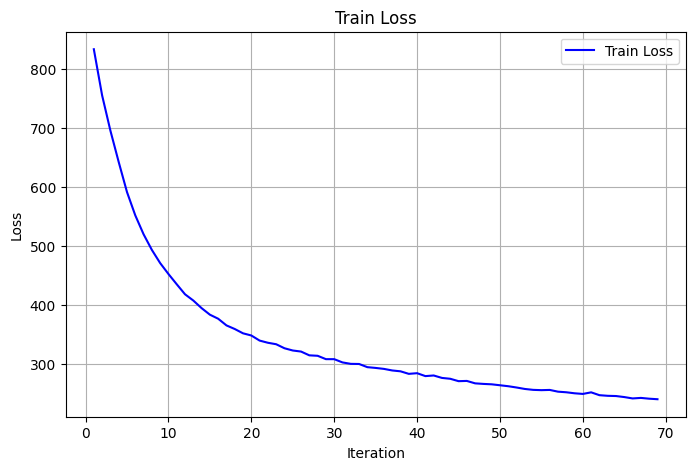

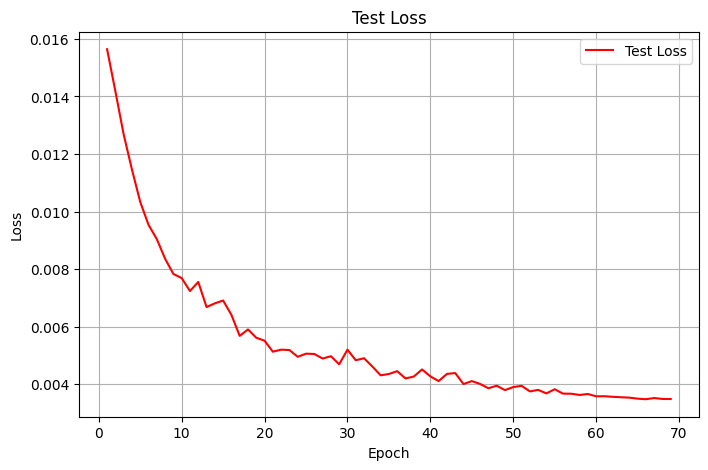

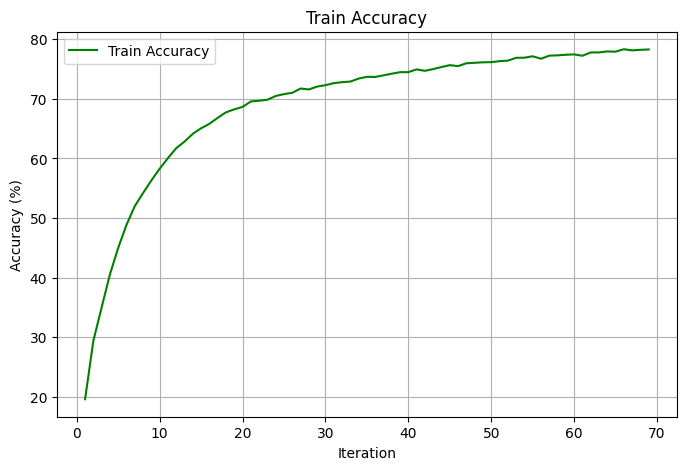

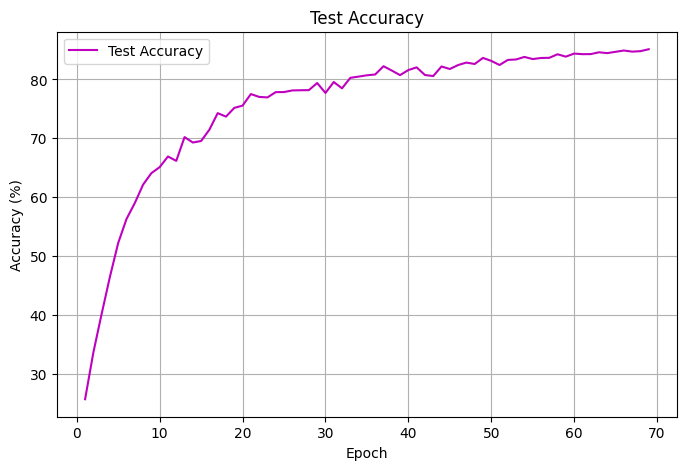

In [3]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from tqdm import tqdm
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import OneCycleLR
# from models import Model1
# from utils import plot_metrics


def train(model, device, train_loader, optimizer, scheduler, criterion, epoch, train_losses, train_acc):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(y_pred, target)   # expects log_softmax in model forward
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        # if batch_idx > 5:
        #     break
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        acc = 100. * correct / processed
        pbar.set_description(desc=f'Epoch={epoch} Loss={loss.item():.4f} Accuracy={acc:0.2f}')
        #train_acc.append(acc)
    train_losses.append(train_loss)
    acc = 100. * correct / len(train_loader.dataset)
    train_acc.append(acc)


def test(model, device, test_loader, criterion, test_losses, test_acc):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc.append(acc)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n')
    return acc

def get_data_loaders():
    # CIFAR-10 mean and std
    CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
    CIFAR10_STD  = (0.2470, 0.2435, 0.2616)


    fill_value_pixels = tuple(int(m * 255) for m in CIFAR10_MEAN)

    train_alb = A.Compose([
        A.HorizontalFlip(p=0.5),
         A.Affine(
            translate_percent={"x": 0.0625, "y": 0.0625},  # shift
            scale=(0.9, 1.1),                               # scale
            rotate=(-15, 15),                               # rotation
            p=0.5
        ),
        A.CoarseDropout(
            num_holes_range=(1, 1),
            hole_height_range=(16, 16),
            hole_width_range=(16, 16),
            fill=fill_value_pixels,
            fill_mask=None,
            p=0.5
        ),
        A.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD),
        ToTensorV2(),
    ])

    val_alb = A.Compose([
        A.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD),
        ToTensorV2(),
    ])

    class AlbCIFAR10(datasets.CIFAR10):
        def __init__(self, root, train=True, transform=None, download=False):
            super().__init__(root=root, train=train, download=download)
            self.alb_transform = transform

        def __getitem__(self, index):
            img, target = self.data[index], int(self.targets[index])
            # img is HxWxC numpy (uint8)
            if self.alb_transform:
                augmented = self.alb_transform(image=img)
                img = augmented["image"]
            else:
                # fallback: convert to tensor and normalize
                img = transforms.ToTensor()(img)
            return img, target



    # train_transforms = transforms.Compose([
    #     transforms.RandomHorizontalFlip(),
    #     transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean, std)
    # ])

    # test_transforms = transforms.Compose([
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean, std)
    # ])

    # train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
    # test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

    train = AlbCIFAR10(root='./data', train=True, transform=train_alb, download=True)
    test   = AlbCIFAR10(root='./data', train=False, transform=val_alb, download=True)

    SEED = 1
    cuda = torch.cuda.is_available()
    print("CUDA Available?", cuda)
    torch.manual_seed(SEED)
    if cuda:
        torch.cuda.manual_seed(SEED)

    dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda \
                      else dict(shuffle=True, batch_size=64)
    train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
    test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
    return train_loader, test_loader, cuda

def perform_training():
    train_loader, test_loader, use_cuda = get_data_loaders()
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Using device:", device)

    number_of_classes = 10
    model = Model1(number_of_classes).to(device)
    summary(model, input_size=(3, 32, 32))  # CIFAR-10 input size

    # return
    #optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
    # optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

    # scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    EPOCHS = 80
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3,
        steps_per_epoch=len(train_loader),

        epochs=EPOCHS,
        pct_start=0.2,
        anneal_strategy="cos",
    )

    EPOCHS = 100
    SAVE_PATH = "best_model.pth"

    train_losses, test_losses, train_acc, test_acc = [], [], [], []
    best_val_acc = 0.0

    for epoch in range(1, EPOCHS + 1):
        print(f"\nEPOCH: {epoch}")
        train(model, device, train_loader, optimizer, scheduler, criterion, epoch, train_losses, train_acc)
        current_test_acc = test(model, device, test_loader, criterion, test_losses, test_acc)
        if current_test_acc >= best_val_acc:
            print("found perfect model!!")
            best_val_acc = current_test_acc
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "val_acc": current_test_acc,
            }, SAVE_PATH)
            print(f"Saved best model (acc={best_val_acc:.2f}%) to {SAVE_PATH}")
            if best_val_acc >= 85.0:
                break

    print("-----------------------------------------")
    print("train accuracies", len(train_acc), train_acc)
    print("train losses", len(train_losses), train_losses)
    print("-----------------------------------------")
    print("-----------------------------------------")
    print("test accuracies", len(test_acc), test_acc)
    print("test losses", len(test_losses), test_losses)
    print("-----------------------------------------")
    plot_metrics(train_losses, test_losses, train_acc, test_acc)

if __name__ == '__main__':
    perform_training()